Data for BTCUSDT added.
Data for ETHUSDT added.
Data for XRPUSDT added.
Data for BNBUSDT added.
Data for SOLUSDT added.
Data for USDCUSDT added.
Data for ADAUSDT added.
Data for DOGEUSDT added.
Data for DOTUSDT added.
Data for LTCUSDT added.
Data for BCHUSDT added.
Data for LINKUSDT added.
Data for XMRUSDT added.
Data for XLMUSDT added.
Data for XTZUSDT added.
Data for TRXUSDT added.
Data for NEOUSDT added.
Data for AVAXUSDT added.
Data for MATICUSDT added.
Data for FTMUSDT added.

Correlation Matrix:
            BTCUSDT   ETHUSDT   XRPUSDT   BNBUSDT   SOLUSDT  USDCUSDT  \
BTCUSDT    1.000000  0.771551  0.392590  0.522760  0.600504 -0.285920   
ETHUSDT    0.771551  1.000000  0.452831  0.553516  0.537181 -0.241105   
XRPUSDT    0.392590  0.452831  1.000000  0.339316  0.420381 -0.130299   
BNBUSDT    0.522760  0.553516  0.339316  1.000000  0.399875 -0.149618   
SOLUSDT    0.600504  0.537181  0.420381  0.399875  1.000000 -0.232243   
USDCUSDT  -0.285920 -0.241105 -0.130299 -0.149618 -0.23

<Axes: >

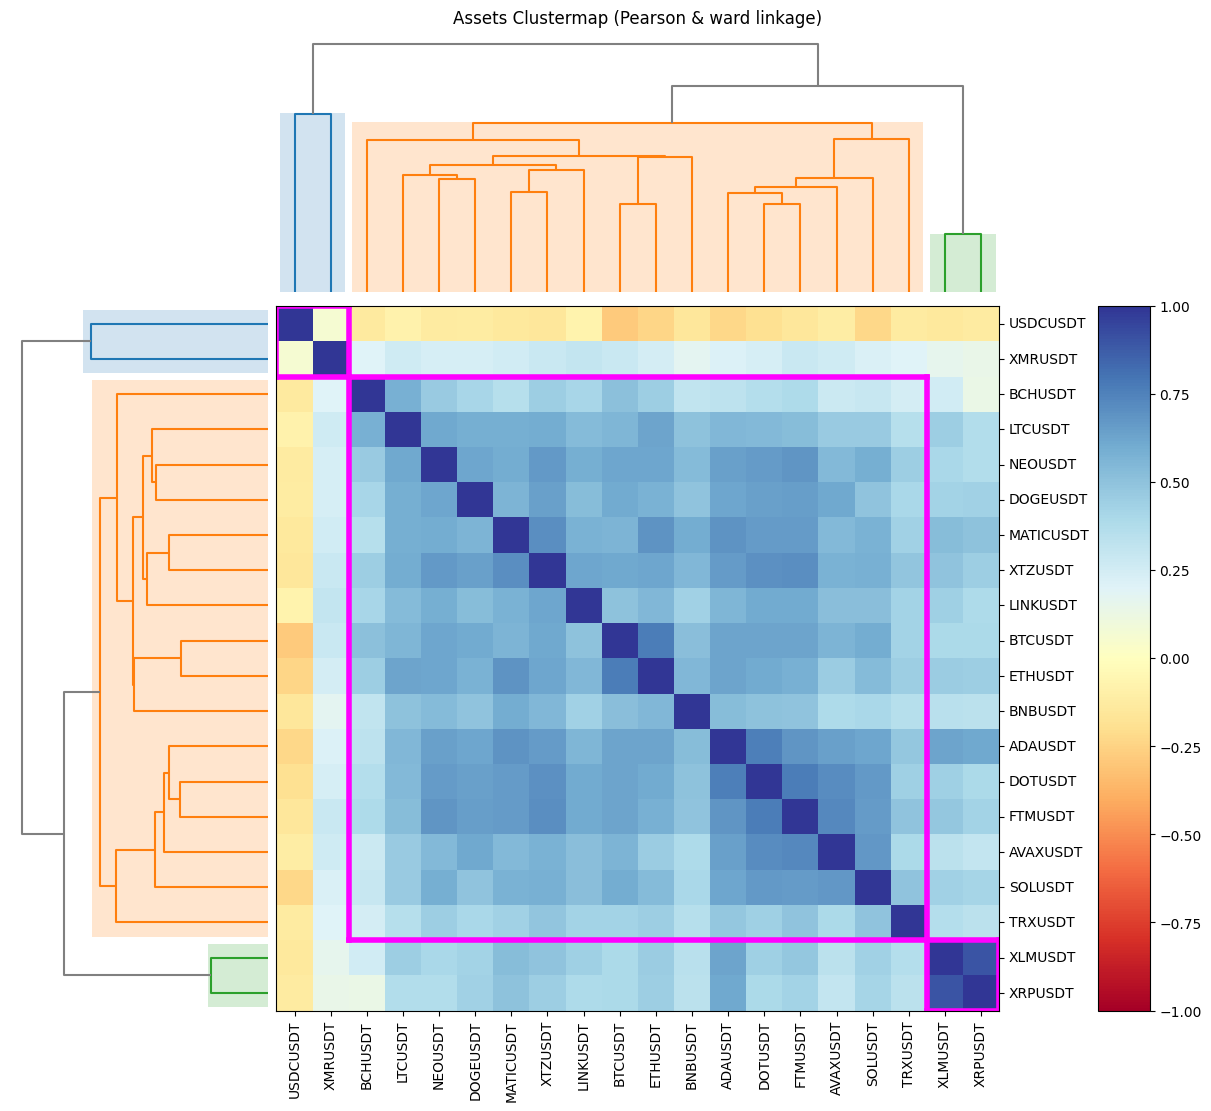

In [6]:
import riskfolio as rp
import pandas as pd
import seaborn as sns
from binance.client import Client
from datetime import datetime, timedelta
import scipy.cluster.hierarchy as sch
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt  # Add this import if not already present




# Load environment variables from .env in project root
load_dotenv()

# Fetch your Binance keys from the environment
api_key = os.getenv("BINANCE_API_KEY")
api_secret = os.getenv("BINANCE_API_SECRET")

# Initialize Binance client
client = Client(api_key, api_secret)

# List of top 20 cryptocurrencies paired with USDT (updated with valid tickers)
assets = [
    "BTCUSDT", "ETHUSDT", "XRPUSDT", "BNBUSDT", "SOLUSDT",
    "USDCUSDT", "ADAUSDT", "DOGEUSDT", "DOTUSDT", "LTCUSDT",
    "BCHUSDT", "LINKUSDT", "XMRUSDT", "XLMUSDT", "XTZUSDT",
    "TRXUSDT", "NEOUSDT", "AVAXUSDT", "MATICUSDT", "FTMUSDT"
]

# Date range for the last 2 years
end_date = datetime.today()
start_date = end_date - timedelta(days=730)  # 2 years

# Initialize an empty DataFrame for storing price data
data = pd.DataFrame()

# Download historical data for each cryptocurrency
for asset in assets:
    try:
        print(f"Downloading data for {asset}")
        candles = client.get_historical_klines(
            asset, 
            Client.KLINE_INTERVAL_1DAY, 
            start_str=str(start_date), 
            end_str=str(end_date)
        )

        # Convert data to DataFrame
        df = pd.DataFrame(candles, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume', 
            'close_time', 'quote_asset_volume', 'number_of_trades', 
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        
        # Convert timestamp to datetime and set it as index
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        
        # Keep only the 'close' column and rename it
        df = df[['close']].rename(columns={'close': asset})

        # Ensure that the 'close' column is numeric
        df[asset] = pd.to_numeric(df[asset], errors='coerce')

        # Drop rows with missing data (NaN values)
        df.dropna(subset=[asset], inplace=True)

        # Merge with the existing data
        data = pd.concat([data, df], axis=1)
        
        print(f"Data for {asset} added.")
    
    except Exception as e:
        print(f"Failed to download {asset}: {e}")

# Check if the data contains any NaN values after download and clean it
data = data.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric
data.dropna(inplace=True)  # Remove rows with NaN values

# Compute returns for the collected data
returns = data.pct_change().dropna()

# Compute and print the correlation matrix
correlation_matrix = returns.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Perform Ward linkage clustering
dist_matrix = sch.distance.pdist(returns.T, metric='euclidean')
linkage_matrix = sch.linkage(dist_matrix, method='ward')

# Print the Ward linkage matrix
print("\nWard Linkage Matrix:")
print(linkage_matrix)

# Compute median returns
median_returns = returns.median().sort_values(ascending=False).to_frame(name="median_return")

# Clustering Correlations
rp.plot_clusters(
    returns=returns,
    codependence="pearson",
    linkage="ward",
    k=None,
    max_k=10,
    leaf_order=True,
    dendrogram=True,
    ax=None
)


In [7]:

# Save the figure as a JPEG image
plt.tight_layout()
plt.savefig("clustered_correlation.png", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>